# Goal of this notebook: identify correlations between STR allele length and gene expression for STR-gene pairs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

## Load expression data, wrangle and split into train and test

In [2]:
df_genexp = pd.read_csv("../../data/gene_expression/dummy_tumor_gene_expression.csv")
df_clinical = pd.read_csv("../../data/dummy_clinical.csv")

df_genexp.sort_values(["gene", "patient"])

,patient,gene,expression
0,1,A,44.418591
1,2,A,46.920442
2,3,A,45.647393
3,4,A,46.452427
4,5,A,44.745364
...,...,...,...
995,46,T,222.590866
996,47,T,234.491680
997,48,T,220.931021
998,49,T,230.089053


In [3]:
df_genexp = (
    df_genexp[['patient', 'gene', 'expression']]
        .pivot_table(
            index='patient', 
            columns='gene', 
            values='expression', 
            aggfunc=sum
        )
)
df_genexp.columns.name = None
df_genexp.index.name = None

print(df_genexp.shape)
df_genexp.head()

(50, 20)


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
1,44.418591,393.517195,325.553885,211.370301,221.215495,413.820832,42.904872,363.007021,102.673416,47.340342,251.745156,466.746417,369.954220,371.443352,376.759793,401.314231,244.252995,65.546985,431.121749,225.822780
2,46.920442,385.881423,317.267282,229.152261,218.760230,442.928094,42.642624,334.766729,102.516263,45.332112,271.994421,474.516605,373.670969,394.689187,365.268049,379.262843,244.576101,65.479270,435.821853,223.527669
3,45.647393,389.524637,320.654782,214.064708,210.485132,420.863358,41.850051,334.675204,96.863451,49.096315,251.311436,503.732754,385.289196,368.128560,370.295520,375.211799,269.672274,65.810945,436.868958,216.714484
4,46.452427,397.255456,329.590480,209.823076,223.599502,413.722106,42.430301,333.652274,105.010037,41.459679,257.230081,493.700570,385.832473,364.222840,373.451687,378.781471,259.175218,64.447576,440.351882,216.577437
5,44.745364,392.213599,316.430470,221.206754,221.674335,447.059633,42.425488,353.493642,96.242895,47.366681,258.637620,494.263559,360.206799,411.392546,369.324475,409.459752,247.411586,61.469537,440.259401,235.175619


Data are split into train and test sets. We randomly take 5 MSS and 5 MSI patients as the test set, leaving 20 MSS and 20 MSI for the training. The training set will be used for eSTR discovery analysis.

In [4]:
test_samples = pd.concat([
    df_clinical.query("MSI == 'MSS'").sample(5, random_state=42),
    df_clinical.query("MSI == 'MSI'").sample(5, random_state=42)
])["patient"].sort_values().values

df_genexp_train = df_genexp.loc[~df_genexp.index.isin(test_samples), : ]
df_genexp_test = df_genexp.loc[df_genexp.index.isin(test_samples), : ]

print(df_genexp_train.shape, df_genexp_test.shape)

(40, 20) (10, 20)


Remove genes where the median expression value == 0

In [5]:
print(df_genexp_train.shape)
df_genexp = df_genexp_train.loc[:, df_genexp_train.median() > 0]
print(df_genexp_train.shape, '\n')

print(df_genexp_test.shape)
df_genexp_test = df_genexp_test.loc[:, df_genexp_test.median() > 0]
print(df_genexp_test.shape, '\n')

(40, 20)
(40, 20) 

(10, 20)
(10, 20) 



Write everything to csv.

In [6]:
df_genexp_train.to_csv("../../data/gene_expression/dummy_tumor_gene_expression_train.csv", index=True, header=True)
df_genexp_test.to_csv("../../data/gene_expression/dummy_tumor_gene_expression_test.csv", index=True, header=True)


## Normalize training data, serialize QuantileTransformer and transformed data

Expression data for the train and test sets are quantile normalized to normal distributions (and then scaled to standard normal). The sklearn QuantileTransformer object is serialized so that it can be used for future transformations. The normalized training data are further processed and eventually will be used to detect correlations between the length of STR loci and gene expression. 

In [7]:
quantile_transformer = QuantileTransformer(random_state=42, output_distribution='normal')

df_genexp_train_trans = pd.DataFrame(
    quantile_transformer.fit_transform(df_genexp_train), 
    index = df_genexp_train.index, 
    columns = df_genexp_train.columns
)

# scale to standard normal
df_genexp_train_trans = (df_genexp_train_trans - df_genexp_train_trans.mean()) / df_genexp_train_trans.std()

df_genexp_test_trans = pd.DataFrame(
    quantile_transformer.transform(df_genexp_test), 
    index = df_genexp_test.index, 
    columns = df_genexp_test.columns
)

# scale to standard normal
df_genexp_test_trans = (df_genexp_test_trans - df_genexp_test_trans.mean()) / df_genexp_test_trans.std()

df_genexp_train_trans.head()

/Users/maxverbiest/miniconda3/envs/STRs-in-CRC/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (40). n_quantiles is set to n_samples.
  warnings.warn(


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
2,0.764003,-0.065001,-0.440564,0.852970,0.065001,0.554325,-0.243154,-0.764003,0.152735,-0.686695,0.852970,-0.617522,0.243154,0.388262,0.440564,-0.495673,-1.312102,0.338207,0.554325,0.021637
3,0.108637,0.152735,-0.289957,-0.338207,-0.617522,-0.243154,-0.686695,-0.960006,-0.617522,0.764003,-1.098998,0.554325,0.960006,-0.617522,0.686695,-0.764003,3.500088,0.495673,0.764003,-0.686695
4,0.617522,0.495673,0.152735,-1.312102,0.617522,-0.554325,-0.338207,-1.312102,0.960006,-1.312102,-0.338207,0.197498,1.312102,-0.852970,0.960006,-0.617522,0.065001,0.021637,3.500088,-0.852970
5,-0.152735,0.197498,-0.495673,0.152735,0.338207,1.312102,-0.388262,0.197498,-1.312102,0.108637,-0.152735,0.243154,-0.197498,0.764003,0.617522,0.764003,-0.764003,-1.312102,1.312102,0.960006
6,-0.338207,0.021637,0.960006,-0.065001,0.388262,-0.440564,-0.495673,-0.152735,-0.243154,0.388262,-0.495673,0.289957,-1.098998,0.152735,-0.440564,-1.098998,0.852970,0.852970,1.098998,0.152735


Looking at one gene pre/post normalization to check effect

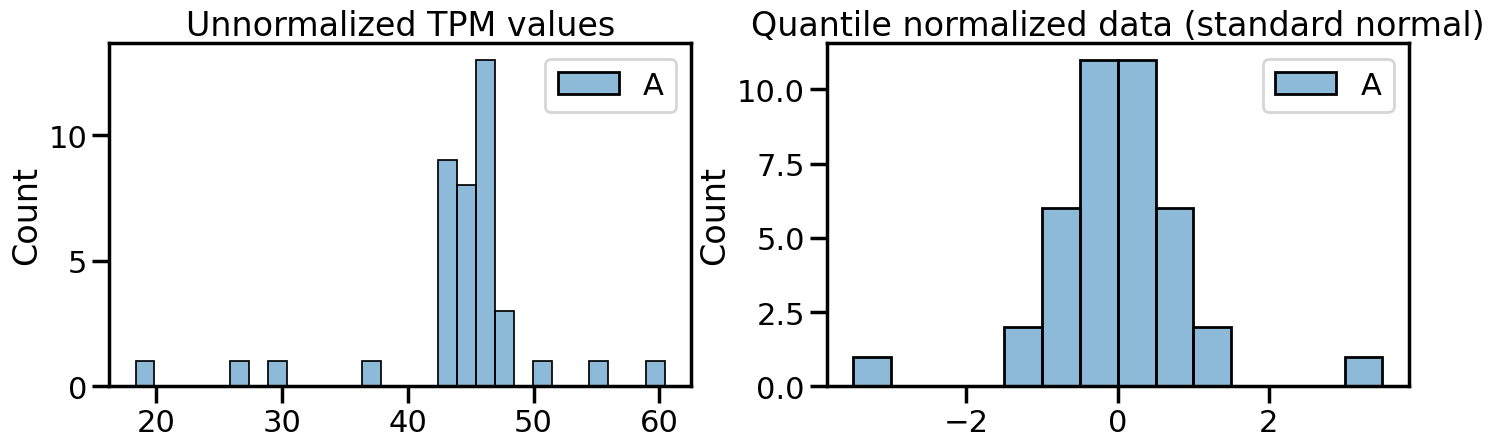

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

gene = "A"

sns.histplot(
    pd.DataFrame(df_genexp_train.loc[:,gene]),
    ax = axes[0]
).set(title='Unnormalized TPM values')

sns.histplot(
    pd.DataFrame(df_genexp_train_trans.loc[:,gene]),
    ax = axes[1]
).set(title='Quantile normalized data (standard normal)')

plt.tight_layout()
plt.show()

In [10]:
def genexp_data_wide_to_long(df):
    df = (df.melt(var_name='gene', value_name='expression', ignore_index=False)
                      .reset_index(drop=False)
                      .rename(columns = {'index': 'patient'}))
    return df

In [11]:
df_genexp_train_trans_long = genexp_data_wide_to_long(df_genexp_train_trans)
df_genexp_test_trans_long = genexp_data_wide_to_long(df_genexp_test_trans)

df_genexp_train_trans_long.head()

,patient,gene,expression
0,2,A,0.764003
1,3,A,0.108637
2,4,A,0.617522
3,5,A,-0.152735
4,6,A,-0.338207


In [12]:
df_genexp_train_trans_long.to_csv("../../data/gene_expression/dummy_tumor_gene_expression_train_normalized.csv", index=False, header=True)
df_genexp_test_trans_long.to_csv("../../data/gene_expression/dummy_tumor_gene_expression_test_normalized.csv", index=False, header=True)


In [13]:
import pickle
with open("../../data/gene_expression/dummy_gene_expression_quantile_transformer.pickle", 'wb') as o:
    pickle.dump(quantile_transformer, o, protocol=-1)
    

# Do correlation testing

In [14]:
df_str_info = pd.read_csv("../../data/dummy_str_regions_filt.csv")
df_tumor_gts = pd.read_csv("../../data/dummy_STR_mutation_data.csv").assign(mean_gt = lambda x: (x.allele_a_tumor + x.allele_b_tumor) / 2)

Make a dictionary where every key is a gene, and the values are all the STR loci that are located in the gene

In [16]:
gene_str_mapping = dict()
for i, row in df_str_info.iterrows():
    str_genes = row['gene'].split(":")
    for gene in str_genes:
        try:
            gene_str_mapping[gene].append(row['tmp_id'])
        except KeyError:
            gene_str_mapping[gene] = [row['tmp_id']]
for k, v in gene_str_mapping.items():
    gene_str_mapping[k] = sorted([*set(v)])

We may not have the genotypes for all STR loci in gene_str_mapping.values(). Below, we first make a set of target_loci, containing all STRs where we have sufficient genotypes. Then, we make a list of tuples representing the all combinations of gene and STR locus where we have genotype information. Only these are use for downstream correlation testing.

In [17]:
target_loci = set(df_tumor_gts.tmp_id.unique())
combinations = []
for gene, loci in gene_str_mapping.items():
    for locus in loci:
        if not locus in target_loci:
            continue
        combinations.append((gene, locus))
print(len(combinations))

1000


In [18]:
import multiprocessing as mp

from statsmodels.stats.multitest import multipletests

from gene_expression_utils import gt_genexp_correlation

In [19]:
%%time

# have to do this so that multiprocessing works from a notebook
if __name__ ==  '__main__': 
    n_processors = 4
    n_combos = len(combinations)
    chunksize = int((n_combos / n_processors) * 0.9)
    
    pool = mp.Pool(n_processors)

    results = pool.imap(gt_genexp_correlation, [(*i, df_tumor_gts, df_genexp_train_trans_long) for i in combinations[ : n_combos]], chunksize)
    pool.close()
    pool.join()
    df_result = pd.concat([i for i in results])


CPU times: user 127 ms, sys: 55.9 ms, total: 183 ms
Wall time: 3.93 s


In [20]:
df_result = (df_result
                 .assign(pvalue_corrected = lambda x: multipletests(x.pvalue_coef, method='fdr_bh')[1])
                 .sort_values("pvalue_coef")
                 .reset_index(drop=True))

df_result.to_csv("../../results/gene_expression/dummy_gene_str_length_correlations.csv", index=False)
df_result

,gene,tmp_id,coefficient,pvalue_coef,intercept,pvalue_corrected
0,B,chr1_1295260,1.299720,3.803179e-12,-6.449859,1.425244e-09
1,N,chr1_10117623,-0.965926,4.672931e-12,11.446221,1.425244e-09
2,A,chr1_1047113,-1.187123,2.371848e-11,4.882045,4.822758e-09
3,J,chr1_6834638,-1.688704,7.793923e-11,30.206693,1.188573e-08
4,P,chr1_10662707,1.756451,6.799050e-09,-8.826168,8.294841e-07
...,...,...,...,...,...,...
605,M,chr1_9554354,0.003433,9.946659e-01,-0.016864,9.966465e-01
606,H,chr1_6462841,-0.001570,9.954960e-01,0.012422,9.966465e-01
607,S,chr1_12256691,0.002606,9.956293e-01,-0.051964,9.966465e-01
608,A,chr1_1228652,-0.002355,9.960506e-01,0.009273,9.966465e-01


In [32]:
df_result.query("pvalue_corrected < 0.001")

,gene,tmp_id,coefficient,pvalue_coef,intercept,pvalue_corrected
0,B,chr1_1295260,1.299720,3.803179e-12,-6.449859,1.425244e-09
1,N,chr1_10117623,-0.965926,4.672931e-12,11.446221,1.425244e-09
2,A,chr1_1047113,-1.187123,2.371848e-11,4.882045,4.822758e-09
3,J,chr1_6834638,-1.688704,7.793923e-11,30.206693,1.188573e-08
4,P,chr1_10662707,1.756451,6.799050e-09,-8.826168,8.294841e-07
5,M,chr1_9691434,1.537430,2.369628e-07,-7.379664,2.409122e-05


## Visualise individual eSTR - gene relationships

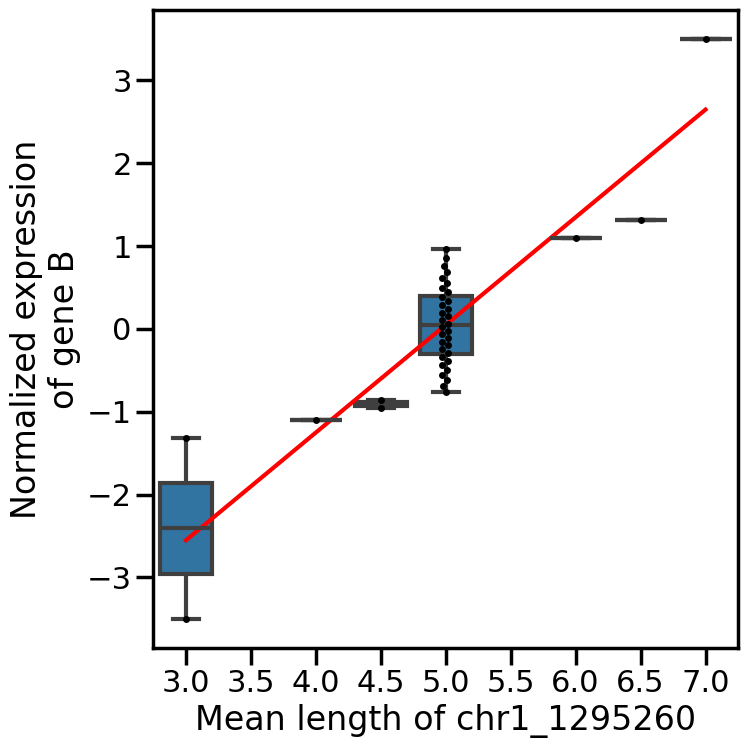

In [35]:
gene = "B"
locus = "chr1_1295260"

df_genexp_cur = df_genexp_train_trans_long.query(f"gene == '{gene}'")[['patient', 'expression']]
df_genotypes_cur = df_tumor_gts.query(f"tmp_id == '{locus}'")[['patient', 'mean_gt']]
df_gt_expression = df_genexp_cur.merge(df_genotypes_cur, on="patient", how="inner").sort_values(by = 'mean_gt')

categories = np.array([i for i in map(str, np.arange(min(df_gt_expression.mean_gt), max(df_gt_expression.mean_gt) + 0.5, 0.5))])
x_axis = pd.Categorical(df_gt_expression.mean_gt.astype(str), categories=categories, ordered=True)

fig = plt.figure(figsize=(8,8))

ax = sns.swarmplot(
    x = x_axis,
    y = df_gt_expression.expression,
    color='black'
)

sns.boxplot(
    x = x_axis,
    y = df_gt_expression.expression,
    color=sns.color_palette()[0],
    ax = ax,
    fliersize=0
)

info_row = df_result.query(f"gene == '{gene}' & tmp_id == '{locus}'").iloc[0,]
sns.lineplot(
    x = x_axis,
    y = (df_gt_expression.mean_gt * info_row.coefficient) + info_row.intercept, 
    ax = ax, 
    color='red'
)

ax.set(xlabel=f"Mean length of {info_row.tmp_id}", ylabel = f"Normalized expression\nof gene {info_row.gene}")
plt.tight_layout()